In [1]:
import json
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

#### 1. Explore correlation coefficients and lasso regression to determine which factors are best for predicting retention.

#### 2. Create a Logistic Regression Model to predict rider retention

In [2]:
#location of data file
file_path = '../ultimate_challenge/ultimate_data_challenge.json'

In [3]:
json_data = json.load(open(file_path))
rider_df = pd.DataFrame(json_data)
rider_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


### Clean Data

In [4]:
# convert last_trip_date and signup_date columns to datetime objects
rider_df.last_trip_date = pd.to_datetime(rider_df.last_trip_date)
rider_df.signup_date = pd.to_datetime(rider_df.signup_date)

# fill rows containing missing ratings
# compute average rating given by all drivers
mean_rating_by_driver = rider_df.avg_rating_by_driver.mean()

# fill average rating by driver with average rating of driver.
rider_df.avg_rating_by_driver = rider_df.avg_rating_by_driver.fillna(rider_df.avg_rating_of_driver)

# fill remaining missing values with oringinal mean of ratings given by drivers
rider_df.avg_rating_by_driver = rider_df.avg_rating_by_driver.fillna(mean_rating_by_driver)

#
rider_df.avg_rating_of_driver = rider_df.avg_rating_of_driver.fillna(rider_df.avg_rating_by_driver)

# if iPhone or Android not specified, insert "other"
rider_df.phone = rider_df.phone.fillna('other')

# fix "King's Landing"
rider_df.city = rider_df.city.replace(to_replace="King's Landing", value="Kings_Landing")
set(rider_df.city)

{'Astapor', 'Kings_Landing', 'Winterfell'}

In [5]:
def rode_recently(last_ride):
    """
    Param: date of last activity
    Used with map() to compute if user was active in the last 30 days
    Returns: boolean (1 or 0)
    """
    current_day = rider_df.last_trip_date.max()
    last_30_days = current_day - timedelta(days=30)
    
    return (last_ride>=last_30_days)*1

In [6]:
# create column describing retention of users
rider_df['retained'] = rider_df.last_trip_date.map(rode_recently)
print("Percent of riders retained: ",rider_df.retained.mean())
print("Total riders retained: ", rider_df.retained.sum(), "of", len(rider_df.retained))

Percent of riders retained:  0.37608
Total riders retained:  18804 of 50000


In [7]:
# define current day outside of the function for efficiency when mapping
current_day = rider_df.last_trip_date.max()
def days_since(date):
    """
    returns the number of days since a given date
    """
    return (current_day - date).days
    
# create 'days_since' columns
#rider_df['days_since_last_trip'] = rider_df.last_trip_date.map(days_since) #this is a direct indicator of the value we are trying to predict
rider_df['days_since_signup'] = rider_df.signup_date.map(days_since)

# compute number of days user has been active
rider_df['days_active'] = (rider_df.last_trip_date - rider_df.signup_date).map(lambda delta: delta.days)


In [8]:
def replace_with_dummies(df, columns):
    """
    Takes a df and a list of categorial columns with discrete values
    Returns a df with categorical columns replaced with binary columns
    """
    for col in columns:
        temp_df= df[[col]]
        temp_df = pd.get_dummies(temp_df)
        df[temp_df.columns] = temp_df
        df = df.drop(col, axis=1)
    return df

# one hot encode categorical columns
rider_df = replace_with_dummies(rider_df, ['city', 'phone'])

# convert ultimate_black_user to numberic boolean column
rider_df.ultimate_black_user = rider_df.ultimate_black_user*1

# drop datetime columns
rider_df = rider_df.drop(['last_trip_date', 'signup_date'], axis=1)
# inspect the dataframe
rider_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
retained                  50000 non-null int64
days_since_signup         50000 non-null int64
days_active               50000 non-null int64
city_Astapor              50000 non-null uint8
city_Kings_Landing        50000 non-null uint8
city_Winterfell           50000 non-null uint8
phone_Android             50000 non-null uint8
phone_iPhone              50000 non-null uint8
phone_other               50000 non-null uint8
dtypes: float64(6), int64(5), uint8(6)
memory usage: 4.5 MB


### Train Random Forrest Classifier

In [9]:
# specify predictors and targets
predictors_rf = rider_df.drop(['retained'], axis="columns").values
targets_rf = rider_df.retained.values

# split train and test data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(predictors_rf, targets_rf, test_size=0.25, random_state=5)


In [10]:
# instantiate random forest classifier
random_forest = RandomForestClassifier(max_depth=True)

# fit model to training data
random_forest = random_forest.fit(X_train_rf, y_train_rf)

# test model performance
print('evaluating Random Forrest model performance')
score_rf = random_forest.score(X_test_rf, y_test_rf)
print(score_rf)


evaluating Random Forrest model performance
0.88488


In [11]:
def evaluate_classifier(model, X_test, y_test):
    
    # get predictions
    y_pred = model.predict(X_test)
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    # compute Area under the curve
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    # plot ROC curve
    title = 'ROC Curve:  AUC =' + str(roc_auc.round(3))
    _ = plt.figure(figsize=(5,5))
    _ = plt.plot(fpr, tpr)
    _ = plt.plot([0,1], [0,1], 'k--')
    _ = plt.xlabel('False Positive Rate (FPR)')
    _ = plt.ylabel('True Positive Rate (TPR)')
    _ = plt.title(title)
    _ = plt.legend(['predictive power','random vector'])
    plt.show()   
    
    
    # construct confusion matrix
    conf_matrx = pd.DataFrame(confusion_matrix(y_test, y_pred))
    conf_matrx.columns = ['Predict: NO', 'Predict: YES']
    conf_matrx.index = ['Actual: NO', 'Actual: YES']
    
    report = classification_report(y_test, y_pred)
    
    return conf_matrx, report

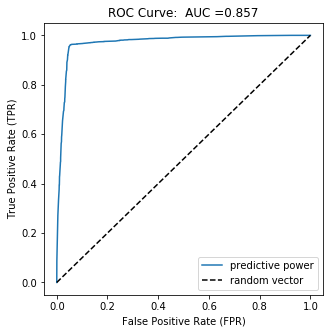

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      7812
           1       0.93      0.75      0.83      4688

    accuracy                           0.88     12500
   macro avg       0.90      0.86      0.87     12500
weighted avg       0.89      0.88      0.88     12500



,Predict: NO,Predict: YES
Actual: NO,7565,247
Actual: YES,1192,3496


In [12]:
matrix, report = evaluate_classifier(random_forest, X_test_rf, y_test_rf)
print(report)
matrix

### Train Logistic Regression Classifier

In [13]:
int("Stop and skip next cell")

ValueError: invalid literal for int() with base 10: 'Stop and skip next cell'

In [ ]:
features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'trips_in_first_30_days',
       'ultimate_black_user', 'weekday_pct', 'city_Astapor',
       "city_Kings_Landing", 'city_Winterfell', 'phone_Android',
       'phone_iPhone', 'phone_other',
       'days_since_signup', 'days_active']

In [14]:
# specify feature columns
features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'trips_in_first_30_days',
       'ultimate_black_user', 'weekday_pct', 'city_Astapor',
       "city_Kings_Landing", 'city_Winterfell', 'phone_Android',
       'phone_iPhone', 'phone_other',
       'days_since_signup']

In [15]:


# separate predictors and targets
predictors_lr = rider_df[features].values
targets_lr = (rider_df.retained).values

In [16]:
# scale predictors
predictors_lr = scale(predictors_lr)

In [17]:
# Split the data into a training and test set.
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(predictors_lr, targets_lr, test_size=0.25, random_state=5)

# instantiate an L.R. Classifier
clf = LogisticRegression(solver='lbfgs')

# Fit the model on the trainng data.
clf.fit(X_train_lr, y_train_lr)

# predict on test set
predictions_lr = clf.predict(X_test_lr)

# Print the accuracy from the testing data.
print(accuracy_score(predictions_lr, y_test_lr))

0.72136


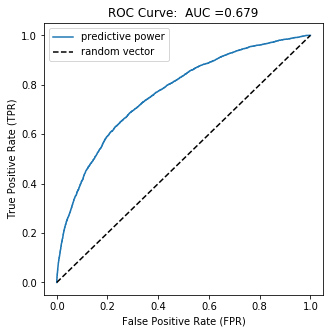

              precision    recall  f1-score   support

           0       0.74      0.85      0.79      7812
           1       0.67      0.51      0.58      4688

    accuracy                           0.72     12500
   macro avg       0.71      0.68      0.68     12500
weighted avg       0.71      0.72      0.71     12500



,Predict: NO,Predict: YES
Actual: NO,6636,1176
Actual: YES,2307,2381


In [18]:
matrix, report = evaluate_classifier(clf, X_test_lr, y_test_lr)
print(report)
matrix

## Include 'Days_active' columns and see noticable difference in predictive power

### Create AUROC graph and find other meaningful methods of scoring. We are interested in targeting users that dropped the service, but were predicted to retain (False Positives). Find the best way to score this

### Use Lasso / Ridge Regression to identify feature significance and predictive power. 

[-0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.02504163987369242, -0.0, -0.007792376923622151, 0.0, -0.0, 0.0]


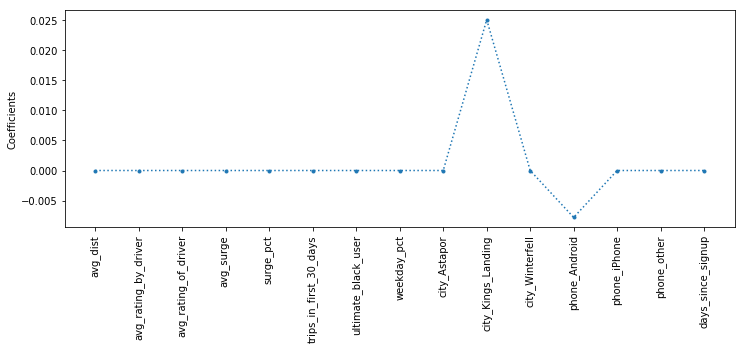

In [19]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(X_train_lr, y_train_lr).coef_
print(list(lasso_coef))


_ = plt.figure(figsize=(12,4))
_ = plt.plot(range(len(features)), lasso_coef, marker='.', linestyle=':')
_ = plt.xticks(range(len(features)), features, rotation=90)
_ = plt.ylabel('Coefficients')

In [ ]:
neural_net_df = rider_df[['retained', 'days_active']]

In [ ]:
color_code = rider_df.retained.map({1:"blue", 0:"red"})

In [ ]:
_ = plt.figure(figsize=(12,1))
_ = plt.scatter(rider_df.days_active, rider_df.retained, color=color_code, alpha=0.1, marker='.')
#_ = plt.axvline(30)
_ = plt.xlabel('Retained')
_ = plt.ylabel('Number of Days Active')
_ = plt.yticks([0,1], ['No', 'Yes'])

In [ ]:
# _ = sns.swarmplot(rider_df.days_active, rider_df.retained)